In [1]:
# importa os pacotes necessários
import numpy as np
import os, cv2, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 


from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import  cross_val_score


from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog

In [2]:
#funções de leitura e preparação das imagens
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))    
    return data

def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
# dois exemplos de descritores. Você deve criar outros mais robustos.
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):     
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #image = cv2.imread(image_file)        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [3]:
TRAIN_DIR = 'kaggle/dogscats/train/'

ROWS = 128
COLS = 128
CHANNELS = 3
NIM = 1000

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] #full dataset: dogs and cats
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# considera apenas NIM imagens. Para o dataset completo, desconsiderar.
train_images = train_dogs[:NIM] + train_cats[:NIM]
random.shuffle(train_images)

# Leitura das imagens
train = prep_data(train_images)
print("Train shape: {}".format(train.shape))

# Cria os labels (rótulos)
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

print(train_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Train shape: (2000, 3, 128, 128)
['kaggle/dogscats/train/cat.10876.jpg', 'kaggle/dogscats/train/cat.10152.jpg', 'kaggle/dogscats/train/dog.10156.jpg', 'kaggle/dogscats/train/cat.10652.jpg', 'kaggle/dogscats/train/dog.10734.jpg', 'kaggle/dogscats/train/cat.10766.jpg', 'kaggle/dogscats/train/cat.10710.jpg', 'kaggle/dogscats/train/dog.1031.jpg', 'kaggle/dogscats/train/dog.10687.jpg', 'kaggle/dogscats/train/cat.10044.jpg', 'kaggle/dogscats/train/cat.1.jpg', 'kaggle/dogscats/train/dog.10185.jpg', 'kaggle/dogscats/train/dog.10424.jpg', 'kaggle/dogscats/train/dog.10521.jpg', 'kaggle/dogscats/train/dog.1005.jpg', 'kaggle/dogscats/train/cat.10880.jpg', 'kaggle/dogscats/train/dog.10024.jpg', 'kaggle/dogscats/train/dog.10539.jpg', 'kaggle/dogscats/train/cat.10125.jpg', 'kaggle/dogscats/train/dog.10519.jpg', 'kaggle/dogsca

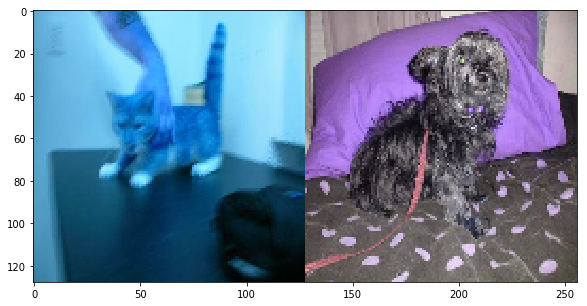

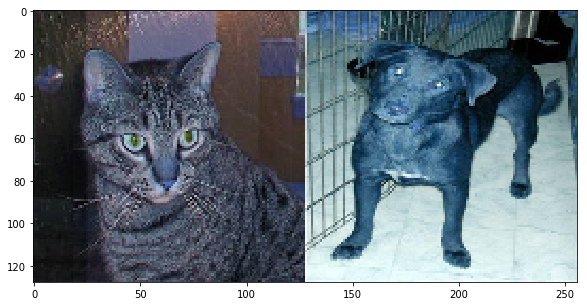

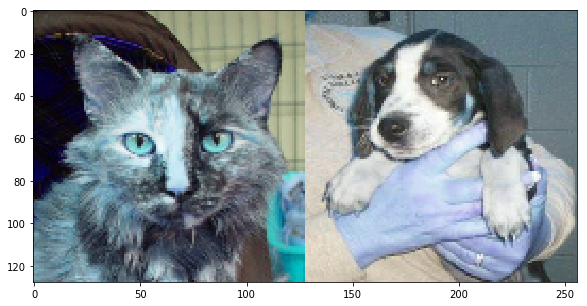

In [4]:
for idx in range(0,3):
    show_cats_and_dogs(idx)

In [5]:
rawImages = []
descHist = []

count = len(train_images)

for i, image_file in enumerate(train_images):
    image = read_image(image_file)
    pixels = image_to_feature_vector(image)
    histogram = extract_color_histogram(image)
    
    rawImages.append(pixels)
    descHist.append(histogram)
        
    if i%250 == 0: print('Processed {} of {}'.format(i, count))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000


In [6]:
#Avalia o primeiro descritor: as imagens raw

(X_train, X_test, y_train, y_test) = train_test_split(
    rawImages, labels, test_size=0.25, random_state=42)

classifiers = [
    KNeighborsClassifier(17),    
    DecisionTreeClassifier(),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))    

KNeighborsClassifier
****Results****
accuracy: 100.00%
DecisionTreeClassifier
****Results****
accuracy: 100.00%
GaussianNB
****Results****
accuracy: 100.00%


In [7]:
#Avalia o segundo descritor: color histogram

(X_train, X_test, y_train, y_test) = train_test_split(
    descHist, labels, test_size=0.25, random_state=42)

classifiers = [
    KNeighborsClassifier(17),    
    DecisionTreeClassifier(),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))   

KNeighborsClassifier
****Results****
accuracy: 100.00%
DecisionTreeClassifier
****Results****
accuracy: 100.00%
GaussianNB
****Results****
accuracy: 100.00%


In [8]:
#Avalia a combinação dos dois primeiros descritores!

#ATENÇÃO: ESTE É APENAS UM CÓDIGO EXEMPLO. VOCÊ DEVE DESENVOLVER
#DESCRITORES MAIS ROBUSTOS, BEM COMO EXPLORAR MELHOR AS MÉTRICAS
#DE AVALIAÇÃO (MATRIZ DE CONFUSÃO, ETC)

trainAux = np.hstack((descHist, rawImages))
(X_train, X_test, y_train, y_test) = train_test_split(
    trainAux, labels, test_size=0.25, random_state=42)

classifiers = [
    KNeighborsClassifier(17),    
    DecisionTreeClassifier(),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))   

KNeighborsClassifier
****Results****
accuracy: 100.00%
DecisionTreeClassifier
****Results****
accuracy: 100.00%
GaussianNB
****Results****
accuracy: 100.00%
